# Molecular Formula Generation

*Blog post by [Jeremy Monat](https://bertiewooster.github.io/)*

In cheminformatics, the typical way of representing a molecule is with a SMILES string such as `CCO` for ethanol. A SMILES string can be converted into a molecular graph, which can be used to determine molecular structure and related properties. However, there are still cases where the molecular formula such as C<sub>2</sub>H<sub>6</sub>O is useful.

For example, the molecular formula is sufficient to determine the molecular mass, to calculate the predicted results from an elemental analysis, to get a sense for the elemental composition of a given molecule, or balancing chemical equations. One of the best-known [chemical equations describes photosynthesis](https://bio.libretexts.org/Bookshelves/Botany/Botany_(Ha_Morrow_and_Algiers)/04%3A_Plant_Physiology_and_Regulation/4.01%3A_Photosynthesis_and_Respiration/4.1.03%3A_Photosynthesis_Overview_and_Equation):

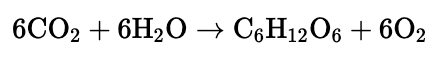

I'm working on a blog post where I need to calculate the molecular formula including isotopes. I was unable to find a package that produced molecular formulas including isotopes from SMILES strings, so I wrote a function to do so. (I tried [chemparse](https://pypi.org/project/chemparse/) and did not succeed.)

In [ ]:
%%capture
!pip install rdkit
%pip install black[jupyter]

In [ ]:
# Mount Google Drive so can read format code in this notebook using black
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Format code using black
# procedure at https://stackoverflow.com/questions/63076002/code-formatter-like-nb-black-for-google-colab#71001241
!black "/content/drive/MyDrive/Colab Notebooks/Molecular Formula Generation.ipynb"

All done! ✨ 🍰 ✨
1 file left unchanged.


In [ ]:
from collections import defaultdict
from IPython.display import display, Markdown

from rdkit import Chem

## Setting up the molecule

Because RDKit excludes hydrogen atoms by default, but we want to include hydrogens in our molecular formula, we tell RDKit to add hydrogens.

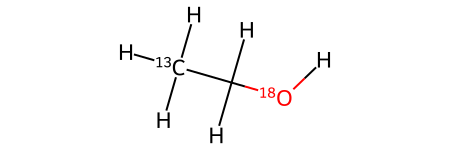

In [ ]:
# Ethanol with isotopes
sml = "[13CH3]C[18OH]"
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

## Composition function

The RDKit does not include a composition function to give the number of each element (including isotopes if desired) in a molecule, so we make one here. It's based on an [algorithm suggested by @IchiruTake](https://github.com/rdkit/rdkit/discussions/5339).

In [ ]:
def composition(
    molecule: Chem.Mol,
    isotopes: bool = False,
) -> defaultdict:
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and isotopes if requested.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :param isotopes: Whether to include the isotope of each atom
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if not molecule:
        return

    # Add hydrogen atoms--RDKit excludes them by default
    molecule = Chem.AddHs(molecule)
    comp = defaultdict(lambda: 0)

    # Get atom counts
    for atom in molecule.GetAtoms():
        element_symbol = atom.GetSymbol()
        # If isotopes not requested, simply count the number of atoms of each element
        if not isotopes:
            comp[element_symbol] += 1
        # If isotopes requested, count the number of each isotope of each element
        else:
            isotope = atom.GetIsotope()
            try:
                comp[element_symbol][isotope] += 1
            except:
                comp[element_symbol] = defaultdict(lambda: 0)
                comp[element_symbol][isotope] += 1
    return comp

With `isotopes=False`, we get the count of each element:

In [ ]:
composition(mol, isotopes=False)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': 2, 'O': 1, 'H': 6})

With `isotopes=True`, the first layer (dictionary) is elements, and the second layer is the isotope and the count:

In [ ]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {13: 1, 0: 1}),
             'O': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {18: 1}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 6})})

## Molecular formula generation

Now that we have the count of each element (with isotopes if desired) in the molecule, we can build the molecular formula. Because of the superscripts for isotopes, and subscripts for counts, we need a formatting language. Our `mol_to_formatted_formula()` provides a dictionary with two options:
- [Markdown](https://en.wikipedia.org/wiki/Markdown), which is commonly converted to HTML. Here the only formatting used are the HTML tags for superscripts and subscripts, so the outputs are valid HTML as well.
- [LaTeX](https://en.wikipedia.org/wiki/LaTeX), which is commonly used for technical papers. LaTeX would overlap a subscript and a superscript that immediately followed it, so we add a small amount of horizontal space using an empty group `{}`.

In [ ]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    if mol is not None:
        comp = composition(mol, isotopes)

        formula = {"markdown": "", "latex": ""}

        if isotopes:
            isotopes_dict = defaultdict(lambda: defaultdict(str))
            subscripts = defaultdict(lambda: defaultdict(int))
            superscripts = defaultdict(list)

            for element, counts in comp.items():
                for isotope, count in counts.items():
                    if count > 1:
                        subscripts[element][isotope] = count
                    if isotope != 0:
                        superscripts[element].append(isotope)

                    isotopes_dict[element][isotope] = 1
                # Sort the element's isotopes from lowest to highest
                superscripts[element].sort()

            last_item_is_subscript = False
            sorted_element_keys = sorted(isotopes_dict.keys())
            for element in sorted_element_keys:
                isotope_count_pairs = isotopes_dict[element]
                # Sort the element's isotopes from lowest to highest
                sorted_isotope_keys = sorted(isotope_count_pairs.keys())
                for isotope in sorted_isotope_keys:
                    if element in superscripts:
                        if isotope in superscripts[element]:
                            formula["markdown"] += f"<sup>{isotope}</sup>"

                            # If superscript immediately follows subscript,
                            # add a small amount of horizontal space using an empty group {}
                            # to prevent them from vertically overlapping
                            if last_item_is_subscript:
                                formula["latex"] += "{}"
                            formula["latex"] += "^{{{}}}".format(isotope)
                            last_item_is_subscript = False
                    formula["markdown"] += element
                    formula["latex"] += element
                    last_item_is_subscript = False
                    if element in subscripts:
                        if isotope in subscripts[element]:
                            isotope_count = subscripts[element][isotope]
                            formula["markdown"] += f"<sub>{isotope_count}</sub>"
                            formula["latex"] += "_{{{}}}".format(isotope_count)
                        last_item_is_subscript = True
            # Add beginning and ending dollar signs to LaTeX formula
            formula["latex"] = "$" + formula["latex"] + "$"
        else:
            # Handling the case when isotopes is False
            sorted_element_keys = sorted(comp.keys())

            for element in sorted_element_keys:
                count = comp[element]
                formula["markdown"] += element
                formula["latex"] += element
                if count > 1:
                    formula["markdown"] += f"<sub>{count}</sub>"
                    formula["latex"] += "_{{{}}}".format(count)
            formula["latex"] = "$" + formula["latex"] + "$"

        return formula
    else:
        return "Invalid molecule"

Here's the Markdown for our isotopic ethanol molecule:

In [ ]:
isotope_formula_markdown = mol_to_formatted_formula(mol, isotopes=True)["markdown"]
isotope_formula_markdown

'C<sup>13</sup>CH<sub>6</sub><sup>18</sup>O'

and we display it as Markdown using `Markdown()`:

In [ ]:
Markdown(isotope_formula_markdown)

C<sup>13</sup>CH<sub>6</sub><sup>18</sup>O

Here's the LaTeX version:

In [ ]:
isotope_formula_latex = mol_to_formatted_formula(mol, isotopes=True)["latex"]
isotope_formula_latex

'$C^{13}CH_{6}{}^{18}O$'

which can also be displayed using `Markdown()`:

In [ ]:
Markdown(isotope_formula_latex)

$C^{13}CH_{6}{}^{18}O$

As far as the order of elements in a chemical formula, `mol_to_formatted_formula()` simply alphabetizes them. So the elements some formulas may not appear in the typical order. Within an element, `mol_to_formatted_formula()` gives the isotopes in increasing order, with the unspecified isotope first.

To go directly from a SMILES string to a formula, we can use this utility function `smiles_to_formatted_formula()`:

In [ ]:
def smiles_to_formatted_formula(smiles: str, isotopes: bool = False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol_to_formatted_formula(mol, isotopes=isotopes)

In [ ]:
isotope_formula_latex_from_smiles = smiles_to_formatted_formula(sml, isotopes=True)[
    "latex"
]
Markdown(isotope_formula_latex_from_smiles)

$C^{13}CH_{6}{}^{18}O$

### Improved formatting using LaTeX

LaTeX italicizes letters by default, so we can use the [LaTeX `\mathrm`](https://www.tutorialspoint.com/tex_commands/mathrm.htm) to make them non-italicized. (The C-style [string substitution using `%`](https://realpython.com/python-string-formatting/#1-old-style-string-formatting-operator) is necessary instead of f-string `{variable}` or `{}.format(variable)` because the braces in those last two interfere with the LaTeX formatting.)

In [ ]:
def markdown_formula(latex: str) -> str:
    latex_markdown = r"$\mathrm{ %s}$" % (latex.strip("$"))
    return latex_markdown

Here's the non-italicized result:

In [ ]:
Markdown(markdown_formula(isotope_formula_latex))

$\mathrm{ C^{13}CH_{6}{}^{18}O}$

As a further utility, we can immediately display the result as Markdown by incorporating that function:

In [ ]:
def display_markdown_formula(latex: str) -> str:
    latex_markdown = r"$\mathrm{ %s}$" % (latex.strip("$"))
    return Markdown(latex_markdown)

In [ ]:
display_markdown_formula(isotope_formula_latex)

$\mathrm{ C^{13}CH_{6}{}^{18}O}$

## Conclusion
Now that we have a way to calculate molecular formulas, and two formats to display them in, the next blog post will give an application of each format.

## Postscript
Here's how to use LaTeX to create the photosynthesis chemical equation shown at the top of the blog post.

In [ ]:
photosynthesis_smls = {
    "Water": "O",
    "Oxygen": "O=O",
    "Carbon Dioxide": "O=C=O",
    "Glucose": "OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O",
}

In [ ]:
mols = {name: Chem.MolFromSmiles(sml) for name, sml in photosynthesis_smls.items()}

In [ ]:
formulas = {
    name: markdown_formula(mol_to_formatted_formula(mol)["latex"])
    for name, mol in mols.items()
}

In [ ]:
photosynthesis = (
    "$"
    + "6"
    + formulas["Carbon Dioxide"].strip("$")
    + "+ 6"
    + formulas["Water"].strip("$")
    + "→"
    + formulas["Glucose"].strip("$")
    + "+ 6"
    + formulas["Oxygen"].strip("$")
    + "$"
)
display(Markdown(photosynthesis))

$6\mathrm{ CO_{2}}+ 6\mathrm{ H_{2}O}→\mathrm{ C_{6}H_{12}O_{6}}+ 6\mathrm{ O_{2}}$